In [92]:
# Useful starting lines
import numpy as np
from proj1_helpers import *
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

from costs import compute_mse, compute_loss
# from plots import *
from helpers import *
# from grid_search import *
# import datetime
# from ridge_regression import *
# from gradient_descent import *
# from stochastic_gradient_descent import *
from implementations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
DATA_PATH_TRAIN = '../data/train.csv'
y_train, data_train, ids_tr = load_csv_data(DATA_PATH_TRAIN, sub_sample=False)
# y_train, data_train, ids_tr = load_csv_data(DATA_PATH_TRAIN, sub_sample=False)

In [67]:
DATA_PATH_TEST = '../data/test.csv'
_, data_test, ids_te = load_csv_data(DATA_PATH_TEST, sub_sample=False)

In [68]:
print(data_train.shape)
print(data_test.shape)

(5000, 30)
(11365, 30)


### Features pre-processing

In [69]:
data_train= put_NaN(data_train)
datasets_train = divide_subset(data_train, y_train)

C:\Users\prisgdd\Documents\EPFL\MachineLearning\projects\ML_project1\scripts\helpers.py:210: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  def divide_subset(data, y = None):


In [70]:
data_test = put_NaN(data_test)
datasets_test = divide_subset(data_test)

In [71]:
test = True
# test = False

# Preprocess datasets_train
for ind, subset_train in enumerate(datasets_train):
    print('Train, before preprocessing : {} '.format(subset_train[0].shape))
    if ind == 0:
        subset_train[0] = preprocess_data_train(subset_train[0], jet = 0)
    elif ind == 1:
        subset_train[0] = preprocess_data_train(subset_train[0], jet = 1)
    elif ind == 2:
        subset_train[0] = preprocess_data_train(subset_train[0], jet = 23)

    print('Train, after preprocessing : {} '.format(subset_train[0].shape))
    datasets_train[ind][0] = subset_train[0]
if test == True:
    print("")
    # Preprocess datasets_train
    for ind, subset_test in enumerate(datasets_test):
        subset_train = datasets_train[ind][0]

        print('Test, before preprocessing : {} '.format(subset_test[0].shape))

        if ind == 0:
            subset_test[0] = preprocess_data_test(subset_test[0], subset_train, jet = 0)
        elif ind == 1:
            subset_test[0] = preprocess_data_test(subset_test[0], subset_train, jet = 1)
        elif ind == 2:
            subset_test[0] = preprocess_data_test(subset_test[0], subset_train, jet = 23)

        print('Test, after preprocessing : {} '.format(subset_test[0].shape))
        datasets_test[ind][0] = subset_test[0]

Train, before preprocessing : (1985, 30) 
Train, after preprocessing : (1985, 18) 
Train, before preprocessing : (1540, 30) 
Train, after preprocessing : (1540, 21) 
Train, before preprocessing : (1475, 30) 
Train, after preprocessing : (1475, 30) 

Test, before preprocessing : (4496, 30) 
Test, after preprocessing : (4496, 18) 
Test, before preprocessing : (3525, 30) 
Test, after preprocessing : (3525, 21) 
Test, before preprocessing : (3344, 30) 
Test, after preprocessing : (3344, 30) 


# 1. Least Square Gradient Descent 


In [99]:
def cross_validation(y, x, k_indices, k, method, max_iters = 0, gamma = 0, lambda_ = 0):
    """return the loss of ridge regression."""

    # get k'th subgroup in test, others in train
    ind_train = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    ind_test = k_indices[k]
    ind_train = ind_train.reshape(-1)
    
    x_train = x[ind_train]
    y_train = y[ind_train]
    x_test = x[ind_test]
    y_test = y[ind_test]
    
    # form data  -- TODO: Change for augmented features
    _, poly_train = build_model_data(x_train, y_train)
    _, poly_test = build_model_data(x_test, y_test)

    if method == least_squares_GD or method == least_squares_SGD or method == logistic_regression:
        initial_w = np.zeros([poly_train.shape[1]])
        w, loss = method(y = y_train, tx = poly_train, initial_w = initial_w, max_iters = max_iters, gamma = gamma)
        
    elif method == least_squares:
        w, loss = method(y = y_train, tx = poly_train)
        
    elif method == ridge_regression:
        w, loss = method(y = y_train, tx = poly_train, lambda_ = lambda_)
        
    elif method == reg_logistic_regression:
        initial_w = np.zeros([poly_train.shape[1]])
        w, loss = method(y = y_train, tx = poly_train, lambda_ = lambda_, initial_w = initial_w, max_iters = max_iters, gamma = gamma)
    
    # Compute prediction for train and test
    y_pred_train = predict_labels(w, poly_train)
    y_pred_test = predict_labels(w, poly_test)
    
    loss_tr = 2 * np.sqrt(2 * compute_loss(y_train, poly_train, w))
    loss_te = 2 * np.sqrt(2 * compute_loss(y_test, poly_test, w))
#     print(" --- y = -1 :: Reel: {} :: Prediction: {}".format( (y_train == -1).sum(), (y_pred_train == -1).sum() )) 
#     print(" --- y = +1 :: Reel: {} :: Prediction: {}".format( (y_train == 1).sum(), (y_pred_train == 1).sum() )) 
    
    # Compute accuracy for train and test 
    accuracy_train = compute_accuracy(y_pred_train, y_train)
    accuracy_test = compute_accuracy(y_pred_test, y_test)
    
    
    return accuracy_train, accuracy_test, w, loss_tr, loss_te



 For case jet = 0 


SUBSET 0 --- lambda_ = 1 :: gamma = 0.4
Average test accuracy: 0.8220766129032258
Variance test accuracy: 0.024480613799558265
Min test accuracy: 0.782258064516129
Max test accuracy: 0.8548387096774194


SUBSET 0 --- lambda_ = 1 :: gamma = 0.5
Average test accuracy: 0.8215725806451613
Variance test accuracy: 0.025161258012799788
Min test accuracy: 0.782258064516129
Max test accuracy: 0.8548387096774194


SUBSET 0 --- lambda_ = 1 :: gamma = 0.6
Average test accuracy: 0.5619959677419355
Variance test accuracy: 0.020053897443626807
Min test accuracy: 0.5362903225806451
Max test accuracy: 0.5967741935483871


SUBSET 0 --- lambda_ = 1 :: gamma = 0.7
Average test accuracy: 0.561491935483871
Variance test accuracy: 0.020236753931335446
Min test accuracy: 0.5362903225806451
Max test accuracy: 0.5967741935483871



 For case jet = 1 


SUBSET 1 --- lambda_ = 1 :: gamma = 0.4
Average test accuracy: 0.72265625
Variance test accuracy: 0.019092289451321843
Min test accuracy: 

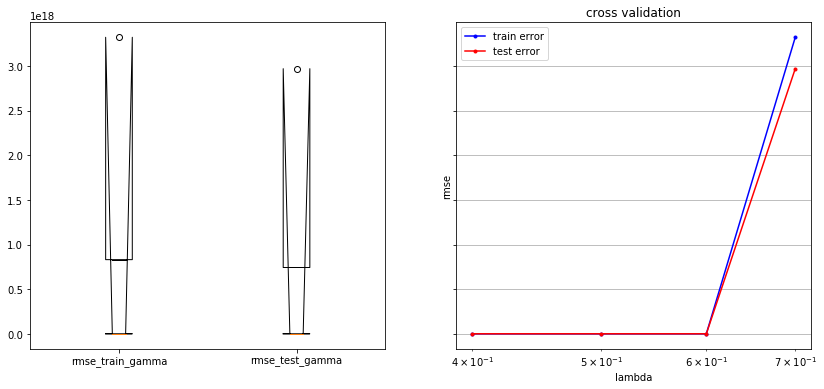

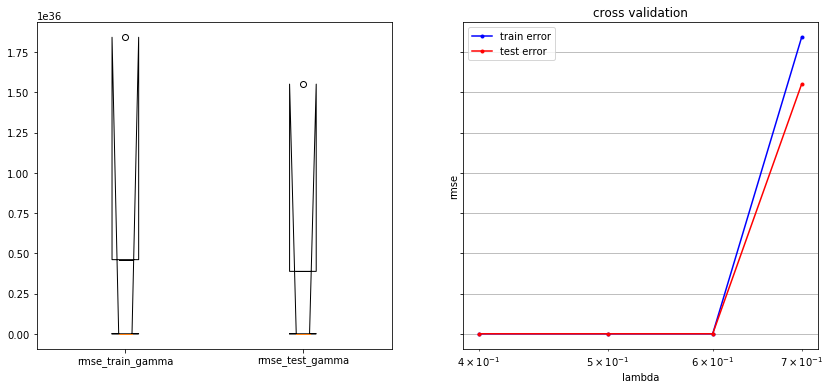

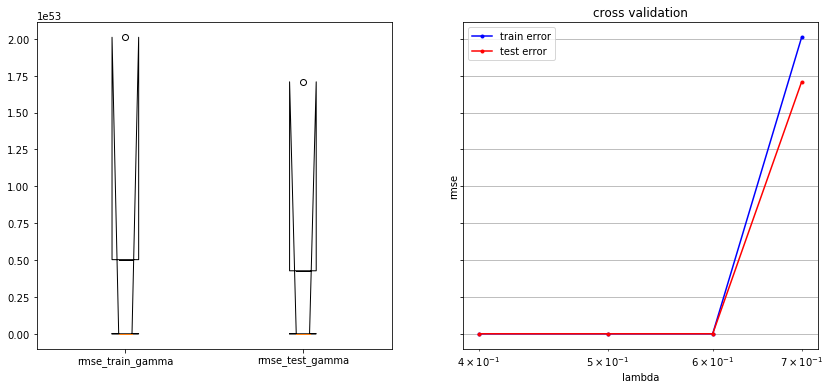

In [100]:
from plots import cross_validation_visualization

# Model parameters
method = least_squares_GD

max_iters = 100
seed = 1
degree = 7
k_fold = 8
# lambdas = np.logspace(-5, 0, 15)
lambdas = []
lambdas.append(1)
gammas = np.arange(0.4, 0.8, 0.1)

y_pred_final = np.zeros((len(ids_te),1))

# For each case (jet = 0, jet = 1, jet = 2,3)
for ind, subset_train in enumerate(datasets_train):
    print("\n\n For case jet = {} \n".format(ind))
    x = subset_train[0]
    y = subset_train[1]
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)

    # define lists to store the accuracy of training data and test data
    accuracy_train = []
    accuracy_test = []

    for lambda_ in lambdas:
        
        accuracy_train_gamma = []
        accuracy_test_gamma = []
        
        rmse_train_gamma = []
        rmse_test_gamma = []
        
        for gamma in gammas:
            param_method = dict(max_iters = max_iters, gamma = gamma, lambda_ = lambda_)

            accuracy_train_k = []
            accuracy_test_k = []
            rmse_train_k = []
            rmse_test_k = []
            w_k = []
            # cross validation  
            for k in range(k_fold):
                accuracy_train_crt, accuracy_test_crt, w, rmse_tr_crt, rmse_te_crt = cross_validation(y, x, k_indices, k, method = method, **param_method)
                accuracy_train_k.append(accuracy_train_crt)
                accuracy_test_k.append(accuracy_test_crt)
                rmse_train_k.append(rmse_tr_crt)
                rmse_test_k.append(rmse_te_crt)
                w_k.append(w)
#                 print("%d - Training accuracy: %f / Test accuracy : %f" % (k, accuracy_train_crt, accuracy_test_crt))

            print("\nSUBSET {} --- lambda_ = {} :: gamma = {}".format(ind, lambda_, gamma))
            print("Average test accuracy: {}".format(np.mean(accuracy_test_k)))
            print("Variance test accuracy: {}".format(np.std(accuracy_test_k)))
            print("Min test accuracy: {}".format(np.min(accuracy_test_k)))
            print("Max test accuracy: {}\n".format(np.max(accuracy_test_k)))   
    
            accuracy_train_gamma.append(np.mean(accuracy_train_k))
            accuracy_test_gamma.append(np.mean(accuracy_test_k))
            
            rmse_train_gamma.append(np.mean(rmse_train_k))
            rmse_test_gamma.append(np.mean(rmse_test_k))
        

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
        axes[0].boxplot([rmse_train_gamma, rmse_test_gamma] , labels=['rmse_train_gamma', 'rmse_test_gamma'], notch=True, bootstrap=10000)
        cross_validation_visualization(gammas, rmse_train_gamma, rmse_test_gamma)

    accuracy_train.append(np.mean(accuracy_train_gamma))
    accuracy_test.append(np.mean(accuracy_test_gamma))
            


    
    
    # ****************************************
    # ****** Predict for datasets_test *******
    # ****************************************
    if test == True:
        subset_test = datasets_test[ind][0]
        _, poly_test = build_model_data(subset_test, datasets_test[ind][1])

        y_pred_crt = predict_labels(w_k[0], poly_test)   # TODO : for now takes the first w
        np.put(y_pred_final, datasets_test[ind][1], y_pred_crt)


In [ ]:
if test == True:
    if method == least_squares_GD:
        create_csv_submission(ids_te, y_pred_final, '../least_squares_GD.csv')
        
    elif method == least_squares_SGD:
        create_csv_submission(ids_te, y_pred_final, '../least_squares_SGD.csv')
        
    elif method == least_squares:
        create_csv_submission(ids_te, y_pred_final, '../least_squares.csv')
        
    elif method == ridge_regression:
        create_csv_submission(ids_te, y_pred_final, '../ridge_regression.csv')
        
    elif method == logistic_regression:
        create_csv_submission(ids_te, y_pred_final, '../logistic_regression.csv')
        
    elif method == reg_logistic_regression:
        create_csv_submission(ids_te, y_pred_final, '../reg_logistic_regression.csv')
        